# Graph Neural Networks for Node Classification with PyTorch Geometric

> Inspired and adapted from the [pytorch geometric tutorials](). 

**Graph Neural Networks (GNNs)** extend traditional deep learning techniques to handle irregular structured data such as graphs.

Most of GNNs operate using a **neural message passing scheme**, where node features $\mathbf{h}_v^{(\ell)}$ of nodes $v \in \mathcal{V}$ in a graph $\mathcal{G} = (\mathcal{V}, \mathcal{E})$ are updated iteratively by aggregating information from their neighbors $\mathcal{N}(v)$:

$$
\mathbf{h}_v^{(\ell + 1)} = f^{(\ell + 1)}_{\theta} \left( \mathbf{h}_v^{(\ell)}, \left\{ \mathbf{h}_w^{(\ell)} : w \in \mathcal{N}(v) \right\} \right)
$$

To understand empirically how it's working, let's, as done before, embed the nodes of the Zachary Karate Club, and compare the GNN approach to other embeddings already seen. 

Note that when loading the Zachary Karate Club dataset with pytorch,  the node's graph are divided into 4 classes, obtained from a clustering using a GCN. Therefore, we will stick with the networkx version of the dataset.



In [26]:
from torch_geometric.utils import from_networkx
import networkx as nx

%matplotlib inline


G = nx.karate_club_graph()
y = [G.nodes[node]['club'] == 'Mr. Hi' for node in G.nodes()]
colors = ['red' if t else 'blue' for t in y]
nx.draw(G, with_labels=True,node_color=y,font_color='white')
G_pytorch = from_networkx(G)



Each graph in PyTorch Geometric is represented by a single [`Data`](https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.Data) object, which holds all the information to describe its graph representation.
We can print the data object anytime via `print(data)` to receive a short summary about its attributes and their shapes.

* edge_index : Graph connectivity in COO format with shape [2, num_edges]
* club : the appartenance of each node to a club
* x : Node feature matrix with shape [num_nodes, num_node_features]. There is no feature matrix in this dataset, so we add a one hot encoding for each node.
* weight : the weight of each edge, inherited from the networkx graph. We will not use it.

In [38]:
G_pytorch.x = torch.eye(G_pytorch.num_nodes)
print(G_pytorch)
edge_index = G_pytorch.edge_index
print(edge_index.t())


Data(edge_index=[2, 156], club=[34], weight=[156], name='Zachary's Karate Club', num_nodes=34, x=[34, 34])
tensor([[ 0,  1],
        [ 0,  2],
        [ 0,  3],
        [ 0,  4],
        [ 0,  5],
        [ 0,  6],
        [ 0,  7],
        [ 0,  8],
        [ 0, 10],
        [ 0, 11],
        [ 0, 12],
        [ 0, 13],
        [ 0, 17],
        [ 0, 19],
        [ 0, 21],
        [ 0, 31],
        [ 1,  0],
        [ 1,  2],
        [ 1,  3],
        [ 1,  7],
        [ 1, 13],
        [ 1, 17],
        [ 1, 19],
        [ 1, 21],
        [ 1, 30],
        [ 2,  0],
        [ 2,  1],
        [ 2,  3],
        [ 2,  7],
        [ 2,  8],
        [ 2,  9],
        [ 2, 13],
        [ 2, 27],
        [ 2, 28],
        [ 2, 32],
        [ 3,  0],
        [ 3,  1],
        [ 3,  2],
        [ 3,  7],
        [ 3, 12],
        [ 3, 13],
        [ 4,  0],
        [ 4,  6],
        [ 4, 10],
        [ 5,  0],
        [ 5,  6],
        [ 5, 10],
        [ 5, 16],
        [ 6,  0],
        [ 6

By printing `edge_index`, we can understand how PyG internally represents graph connectivity.
For each edge, `edge_index` contains a pair of node indices: the first value indicates the source node, and the second value indicates the destination node.

This representation is known as the **COO format (coordinate format)**, commonly used for sparse matrices.
Instead of storing adjacency information in a dense matrix $\mathbf{A} \in \{ 0, 1 \}^{|\mathcal{V}| \times |\mathcal{V}|}$, PyG uses a sparse representation, holding only the coordinates/values where entries in $\mathbf{A}$ are non-zero.

Importantly, PyG treats undirected graphs as a special case of directed graphs, where reverse edges exist for every entry in `edge_index`.


## Implementing a First GNN

First, we will use a simple Graph Neural Network to embed the nodes of the Zachary Karate Club graph, the **GCN layer** ([Kipf et al. (2017)](https://arxiv.org/abs/1609.02907)), which is defined as

$$
\mathbf{x}_v^{(\ell + 1)} = \mathbf{W}^{(\ell + 1)} \sum_{w \in \mathcal{N}(v) \, \cup \, \{ v \}} \frac{1}{c_{w,v}} \cdot \mathbf{x}_w^{(\ell)}
$$

where $\mathbf{W}^{(\ell + 1)}$ denotes a trainable weight matrix of shape `[num_output_features, num_input_features]` and $c_{w,v}$ refers to a fixed normalization coefficient for each edge.

PyG implements this layer via [`GCNConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv), which can be executed by passing in the node feature representation `x` and the COO graph connectivity representation `edge_index`, both encoded within our graph.

With this, we are ready to create our first Graph Neural Network by defining our network architecture in a `torch.nn.Module` class:

In [44]:
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self, num_features=34, num_classes=2):
        super().__init__()
        self.conv1 = GCNConv(num_features, 4)
        self.conv2 = GCNConv(4, 2)
        self.classifier = Linear(2, num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        # Apply a final (linear) classifier.
        out = self.classifier(x)

        return out, x

model = GCN()
print(model)

GCN(
  (conv1): GCNConv(34, 4)
  (conv2): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=2, bias=True)
)


Here, we first initialize all of our building blocks in `__init__` and define the computation flow of our network in `forward`.
We first define and stack **two graph convolution layers**, which corresponds to aggregating 2-hop neighborhood information around each node (all nodes up to 2 "hops" away).
In addition, the `GCNConv` layers reduce the node feature dimensionality to $2$ for visualization purpose, *i.e.*, $34 \rightarrow 4 \rightarrow 2$. Each `GCNConv` layer is enhanced by a ReLu to induce non-linearity.

After that, we apply a single linear transformation ([`torch.nn.Linear`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html?highlight=linear#torch.nn.Linear)) that acts as a classifier to map our nodes to 1 out of the 2 classes/communities.

We return both the output of the final classifier as well as the final node embeddings produced by our GNN.
We proceed to initialize our final model via `GCN()`, and printing our model produces a summary of all its used sub-modules.


## Computing Node Embedding of the Karate Club

Let's have a look at the node embeddings produced by our GNN before any learning.
Here, we pass in the initial dummy node features `x` and the graph connectivity information `edge_index` to the model, and visualize its 2-dimensional embedding.

Embedding shape: [34, 2]


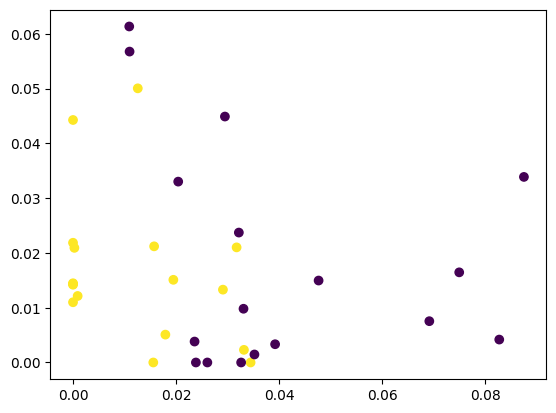

In [47]:
import matplotlib.pyplot as plt 
model = GCN()

pred, proj = model(G_pytorch.x, G_pytorch.edge_index)
print(f'Embedding shape: {list(x.shape)}')

proj = proj.detach().numpy()
plt.scatter(proj[:,0],proj[:,1], c=y)

Remarkably, even before training the weights of our model, the model produces an embedding of nodes that closely resembles the community-structure of the graph.
Nodes of the same color (community) are already closely clustered together in the embedding space, although the weights of our model are initialized **completely at random** and we have not yet performed any training so far!
This leads to the conclusion that GNNs introduce a strong inductive bias, leading to similar embeddings for nodes that are close to each other in the input graph.

## Training on the Karate Club Network

To do better, we can compute an embedding which separates the nodes of the two communities better.
To achieve this, we will train our model to discriminate between the two classes by minimizing a cross-entropy loss between the predicted class probabilities and the ground-truth labels.

Training our model is very similar to any other PyTorch model.
In addition to defining our network architecture, we define a loss critertion (here, [`CrossEntropyLoss`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)) and initialize a stochastic gradient optimizer (here, [`Adam`](https://pytorch.org/docs/stable/optim.html?highlight=adam#torch.optim.Adam)).

After that, we perform multiple rounds of optimization, where each round consists of a forward and backward pass to compute the gradients of our model parameters w.r.t. to the loss derived from the forward pass.

If you need ressources to train a pytorch model, the PyTorch docs provide [a good introduction on how to train a neural network in PyTorch](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#define-a-loss-function-and-optimizer).



Here, we make use of a semi-supervised or transductive learning procedure: We simply train against one node per class, but are allowed to make use of the complete input graph data. The semi-supervised learning scenario is achieved by defining a mask indicating which nodes are used to train the embeddings.

While we compute node embeddings for all of our nodes, we **only make use of the training nodes for computing the loss**.

Let us now start training and see how our node embeddings evolve over epochs

In [60]:
import random

true_indices = [i for i, val in enumerate(y) if val]
false_indices = [i for i, val in enumerate(y) if not val]

random_true_index = random.choice(true_indices)
random_false_index = random.choice(false_indices)

random_true_index, random_false_index
train_mask = torch.zeros(G_pytorch.num_nodes, dtype=torch.bool)
train_mask[random_true_index] = True
train_mask[random_false_index] = True


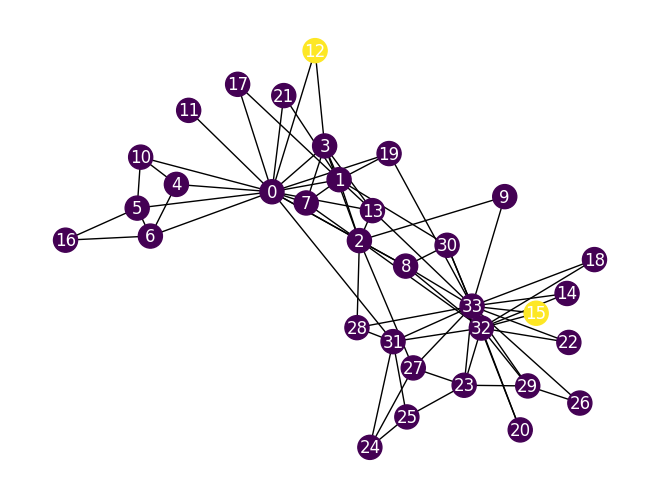

In [61]:
nx.draw(G, with_labels=True,node_color=train_mask,font_color='white')


In [75]:
print(y_pytorch.dtype)
print(dataset[0].y.dtype)

torch.float32
torch.int64


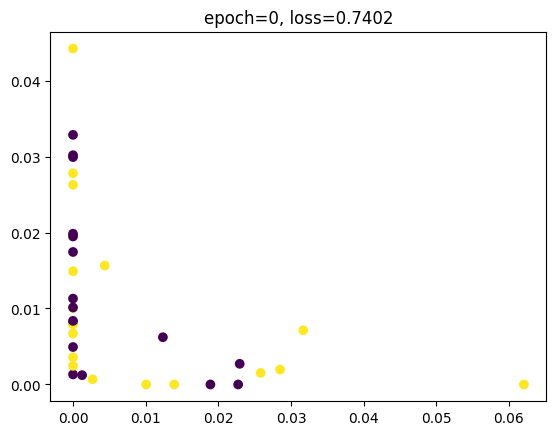

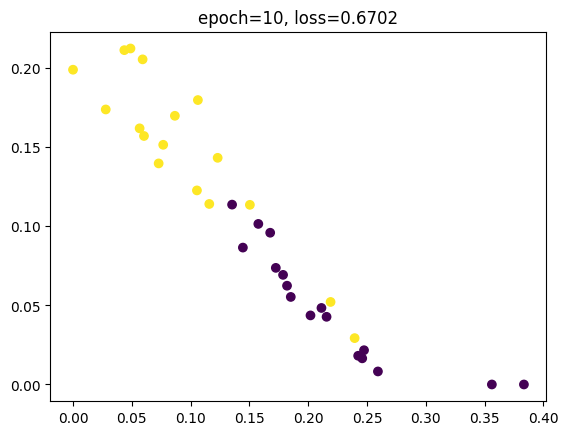

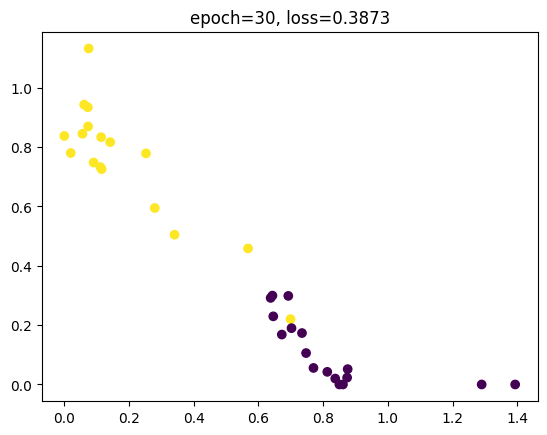

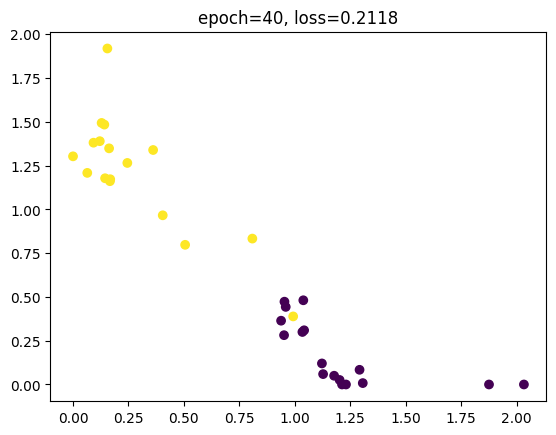

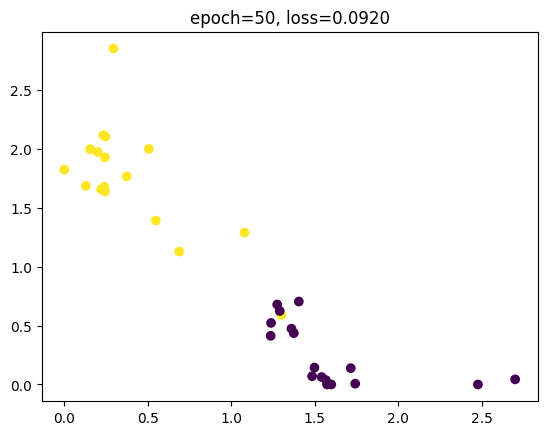

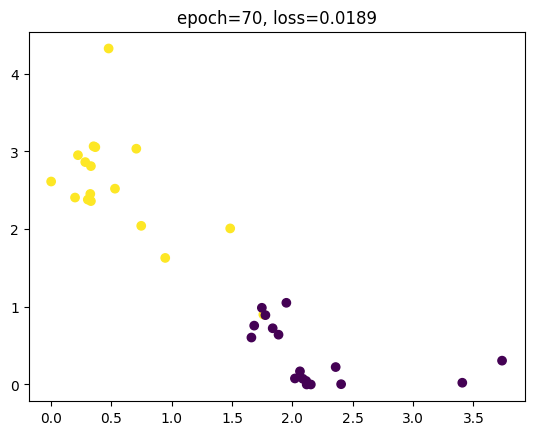

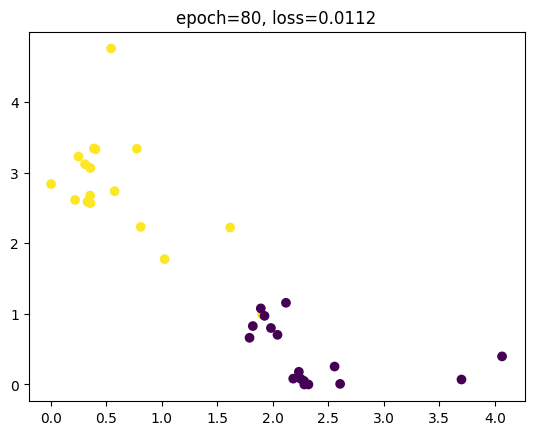

In [86]:
y_pytorch = torch.tensor(y, dtype=torch.int64)
model = GCN(num_features=34, num_classes=2)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Define optimizer.
import time

def train(data):
    optimizer.zero_grad()  # Clear gradients.
    out, proj = model(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out[train_mask], y_pytorch[train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss, proj


for epoch in range(101):
    loss, proj = train(G_pytorch)
    if epoch % 10 == 0:
        proj = proj.detach().numpy()
        plt.figure()
        plt.scatter(proj[:,0], proj[:,1], c=y)
        plt.title(f"{epoch=}, loss={loss.item():.4f}")
        plt.show()

As one can see, our 2-layer GCN model manages to linearly separating the communities and classifying most of the nodes correctly.


# Advanced Node Classification with GNN

Here, we are given the ground-truth labels of only a small subset of nodes, and want to infer the labels for all the remaining nodes (*transductive learning*).

To demonstrate, we make use of the `Cora` dataset, which is a **citation network** where nodes represent documents. Here, we are given a bag-of-words feature representation for each document, and edges represent citations between documents. The task is to infer the category of each document. In this notebook, we will use the node features to predict the category of each document.


In [87]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='./data/Cora', name='Cora', transform=NormalizeFeatures())

data = dataset[0]  
print(data)

print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Processing...


Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True


Done!


For training this dataset, we are given the ground-truth categories of 140 nodes (20 for each class). This results in a training node label rate of only 5%.

In contrast to `KarateClub`, this graph holds the additional attributes `val_mask` and `test_mask`, which denotes which nodes should be used for validation and testing.
Furthermore, we make use of **[data transformations](https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html#data-transforms) via `transform=NormalizeFeatures()`**.
Transforms can be used to modify your input data before inputting them into a neural network, *e.g.*, for normalization or data augmentation.
Here, we [row-normalize](https://pytorch-geometric.readthedocs.io/en/latest/modules/transforms.html#torch_geometric.transforms.NormalizeFeatures) the bag-of-words input feature vectors.

We can further see that this network is undirected, and that there exists no isolated nodes (each document has at least one citation).

## Training a Multi-layer Perception Network (MLP)

In theory, we should be able to infer the category of a document solely based on its content, *i.e.* its bag-of-words feature representation, without taking any relational information into account.

Let's verify that by constructing a simple MLP that solely operates on input node features (using shared weights across all nodes). This first model, independant from the graph, will serve as a baseline for our later GNN model.

In [88]:
import torch
from torch.nn import Linear
import torch.nn.functional as F


class MLP(torch.nn.Module):
    def __init__(self, num_features, num_classes, hidden_channels):
        super().__init__()
        self.lin1 = Linear(num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, num_classes)

    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = self.lin2(x)
        return x

model = MLP(num_features = dataset.num_features, num_classes=dataset.num_classes,
            hidden_channels=16)
print(model)

MLP(
  (lin1): Linear(in_features=1433, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=7, bias=True)
)


Our MLP is defined by two linear layers and enhanced by [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html?highlight=relu#torch.nn.ReLU) non-linearity.

Here, we first reduce the 1433-dimensional feature vector to a low-dimensional embedding (`hidden_channels=16`), while the second linear layer acts as a classifier that should map each low-dimensional node embedding to one of the 7 classes.

Let's train our simple MLP by following a similar procedure as earlier.
This time, we also define a **`test` function** to evaluate how well our final model performs on the test node set (which labels have not been observed during training).

In [93]:
model = MLP(dataset.num_features, dataset.num_classes, hidden_channels=16)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Define optimizer.

def train(data):
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test(data):
      model.eval()
      out = model(data.x)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc

losses = []
test_accs = []
for epoch in range(1, 201):
      loss = train(data)
      test_accs.append(test(data))
      losses.append(loss.item())
      print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(losses, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:red'
ax2.set_ylabel('Test Accuracy', color=color)  # we already handled the x-label with ax1
ax2.plot(test_accs, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

Epoch: 001, Loss: 1.9589
Epoch: 002, Loss: 1.9530
Epoch: 003, Loss: 1.9457
Epoch: 004, Loss: 1.9372
Epoch: 005, Loss: 1.9275
Epoch: 006, Loss: 1.9168
Epoch: 007, Loss: 1.9049
Epoch: 008, Loss: 1.8921
Epoch: 009, Loss: 1.8784
Epoch: 010, Loss: 1.8638
Epoch: 011, Loss: 1.8482
Epoch: 012, Loss: 1.8316
Epoch: 013, Loss: 1.8140
Epoch: 014, Loss: 1.7952
Epoch: 015, Loss: 1.7753
Epoch: 016, Loss: 1.7543
Epoch: 017, Loss: 1.7321
Epoch: 018, Loss: 1.7087
Epoch: 019, Loss: 1.6841
Epoch: 020, Loss: 1.6584
Epoch: 021, Loss: 1.6316
Epoch: 022, Loss: 1.6035
Epoch: 023, Loss: 1.5742
Epoch: 024, Loss: 1.5437
Epoch: 025, Loss: 1.5119
Epoch: 026, Loss: 1.4789
Epoch: 027, Loss: 1.4446
Epoch: 028, Loss: 1.4092
Epoch: 029, Loss: 1.3729
Epoch: 030, Loss: 1.3358
Epoch: 031, Loss: 1.2979
Epoch: 032, Loss: 1.2594
Epoch: 033, Loss: 1.2204
Epoch: 034, Loss: 1.1811
Epoch: 035, Loss: 1.1416
Epoch: 036, Loss: 1.1021
Epoch: 037, Loss: 1.0626
Epoch: 038, Loss: 1.0233
Epoch: 039, Loss: 0.9844
Epoch: 040, Loss: 0.9460


After training the model, we can call the `test` function to see how well our model performs on unseen labels.
Here, we are interested in the accuracy of the model, *i.e.*, the ratio of correctly classified nodes:

In [95]:
test_acc = test(data)
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.5980


As one can see, our MLP performs rather bad with only about 59% test accuracy.
But why does the MLP do not perform better?
The main reason for that is that this model suffers from heavy overfitting due to only having access to a **small amount of training nodes**, and therefore generalizes poorly to unseen node representations.

It also fails to incorporate an important bias into the model: **Cited papers are very likely related to the category of a document**.
That is exactly where Graph Neural Networks come into play and can help to boost the performance of our model.



## Training a Graph Neural Network (GNN)

We can easily convert our MLP to a GNN by swapping the `torch.nn.Linear` layers with a GNN convolution layer.

In [99]:
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self,num_features, num_classes, hidden_channels):
        super().__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        return x

model = GCN(num_features=dataset.num_features,
            num_classes=dataset.num_classes,
            hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


Let's visualize the node embeddings of our **untrained** GCN network.
For visualization, we make use of [**TSNE**](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) to embed our 7-dimensional node embeddings onto a 2D plane.

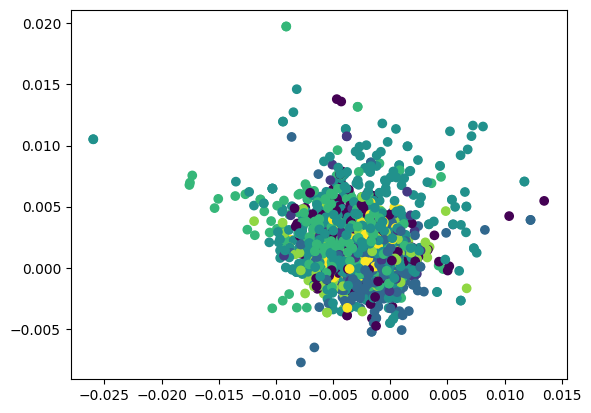

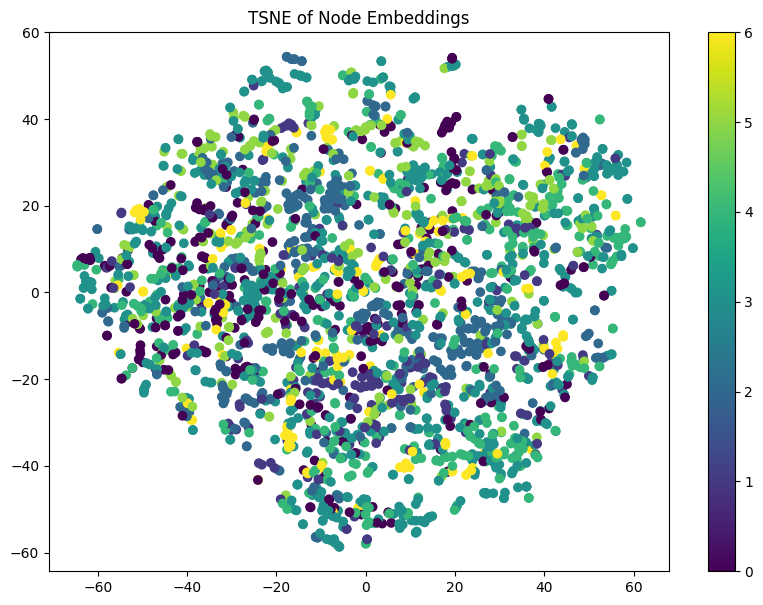

In [107]:
from sklearn.manifold import TSNE

model = GCN(num_features=dataset.num_features,
            num_classes=dataset.num_classes,
            hidden_channels=16)
model.eval()

out = model(data.x, data.edge_index)
proj = out.detach().numpy()
tsne = TSNE(n_components=2)
proj_tsne = tsne.fit_transform(proj)

plt.figure(figsize=(10, 7))
plt.scatter(proj_tsne[:, 0], proj_tsne[:, 1], c=data.y, cmap='viridis')
plt.colorbar()
plt.title('TSNE of Node Embeddings')
plt.show()

We certainly can do better by training our model.
The training and testing procedure is once again the same, but this time we make use of the node features `x` **and** the graph connectivity `edge_index` as input to our GCN model.

Epoch: 001, Loss: 1.9458
Epoch: 002, Loss: 1.9416
Epoch: 003, Loss: 1.9364
Epoch: 004, Loss: 1.9277
Epoch: 005, Loss: 1.9180
Epoch: 006, Loss: 1.9088
Epoch: 007, Loss: 1.8981
Epoch: 008, Loss: 1.8862
Epoch: 009, Loss: 1.8735
Epoch: 010, Loss: 1.8600
Epoch: 011, Loss: 1.8457
Epoch: 012, Loss: 1.8304
Epoch: 013, Loss: 1.8140
Epoch: 014, Loss: 1.7972
Epoch: 015, Loss: 1.7798
Epoch: 016, Loss: 1.7617
Epoch: 017, Loss: 1.7429
Epoch: 018, Loss: 1.7233
Epoch: 019, Loss: 1.7030
Epoch: 020, Loss: 1.6822
Epoch: 021, Loss: 1.6607
Epoch: 022, Loss: 1.6386
Epoch: 023, Loss: 1.6161
Epoch: 024, Loss: 1.5930
Epoch: 025, Loss: 1.5694
Epoch: 026, Loss: 1.5453
Epoch: 027, Loss: 1.5207
Epoch: 028, Loss: 1.4956
Epoch: 029, Loss: 1.4702
Epoch: 030, Loss: 1.4444
Epoch: 031, Loss: 1.4182
Epoch: 032, Loss: 1.3917
Epoch: 033, Loss: 1.3650
Epoch: 034, Loss: 1.3381
Epoch: 035, Loss: 1.3110
Epoch: 036, Loss: 1.2838
Epoch: 037, Loss: 1.2566
Epoch: 038, Loss: 1.2294
Epoch: 039, Loss: 1.2022
Epoch: 040, Loss: 1.1751


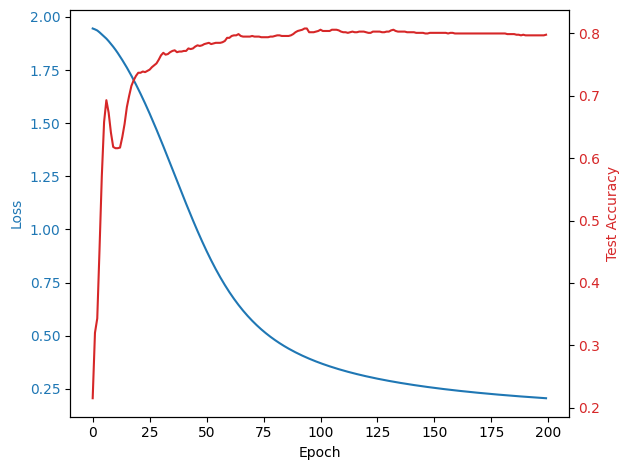

In [109]:
model = GCN(num_features=dataset.num_features,
            num_classes=dataset.num_classes,
            hidden_channels=16)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train(data):
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test(data):
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc


losses = []
test_accs = []
for epoch in range(1, 201):
      loss = train(data)
      test_accs.append(test(data))
      losses.append(loss.item())
      print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(losses, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:red'
ax2.set_ylabel('Test Accuracy', color=color)  # we already handled the x-label with ax1
ax2.plot(test_accs, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

After training the model, we can check its test accuracy:

In [110]:
test_acc = test(data)
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.7980


By simply taking account the neighbours of each paper, we leverage our accuracy to about 81%.

We can also verify that once again by looking at the output embeddings of our **trained** model, which now produces a far better clustering of nodes of the same category.

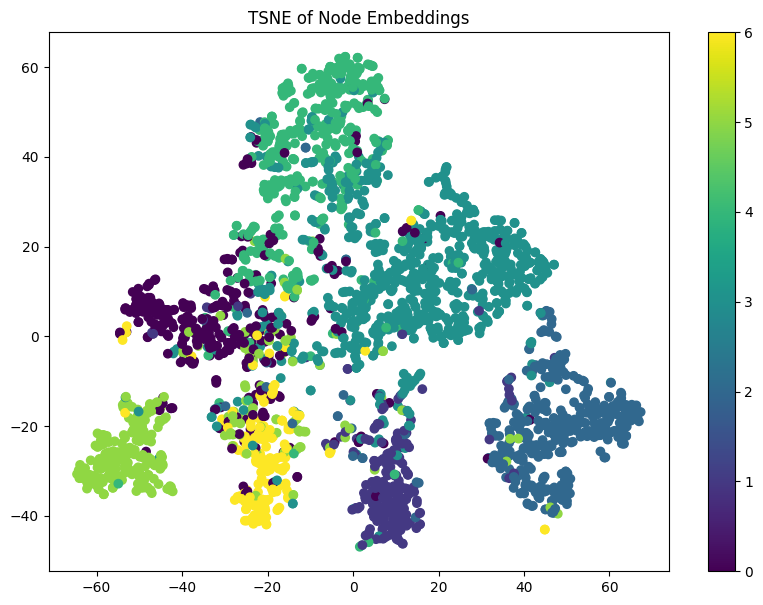

In [111]:
model.eval()
out = model(data.x, data.edge_index)
proj = out.detach().numpy()
tsne = TSNE(n_components=2)
proj_tsne = tsne.fit_transform(proj)

plt.figure(figsize=(10, 7))
plt.scatter(proj_tsne[:, 0], proj_tsne[:, 1], c=data.y, cmap='viridis')
plt.colorbar()
plt.title('TSNE of Node Embeddings')
plt.show()

Use the validation set, encoded by `data.val_mask`, to optimize hyperparameters, epochs, or the architecture. You can try to use different GNN layers implemented within the pytorch geometric library.